In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

# Paths
train_dir = "/content/drive/My Drive/classification_garbage/train/with_label"
unlabeled_dir = "/content/drive/My Drive/classification_garbage/train/no_label"
test_dir = "/content/drive/My Drive/classification_garbage/test"

# Ensure the directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Error: Directory '{train_dir}' not found!")
if not os.path.exists(unlabeled_dir):
    raise FileNotFoundError(f"Error: Directory '{unlabeled_dir}' not found!")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Error: Directory '{test_dir}' not found!")

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load labeled data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset="training"
)
val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    subset="validation"
)

# Fix: Define input explicitly
input_tensor = Input(shape=(224, 224, 3))

# Load pre-trained MobileNetV2
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze layers

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # Binary classification

# Fix: Ensure proper connection of the model
model = Model(inputs=base_model.input, outputs=x)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train on small labeled dataset
model.fit(train_data, validation_data=val_data, epochs=10)

# Save model
model.save("/content/drive/My Drive/classification_garbage/garbage_classifier.h5")


Mounted at /content/drive
Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


<ipython-input-5-ce81c685a2bd>:57: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_156']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - accuracy: 0.5417 - loss: 0.9846 - val_accuracy: 0.6250 - val_loss: 0.5636
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6458 - loss: 0.6517 - val_accuracy: 0.5000 - val_loss: 0.8899
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5208 - loss: 0.8551 - val_accuracy: 0.7500 - val_loss: 0.5009
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8542 - loss: 0.3685 - val_accuracy: 0.6250 - val_loss: 0.5376
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8125 - loss: 0.3507 - val_accuracy: 0.7500 - val_loss: 0.4741
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9583 - loss: 0.2440 - val_accuracy: 0.7500 - val_loss: 0.5825
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.8125 - loss: 0.3748 - val_accuracy: 0.7500 - val_loss: 0.4893
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.9792 - loss: 0.1832 - val_accuracy: 0.6250 - val_loss: 0.3813
Epoch 9/10
2/2 ━━━━━━━━━━━

In [ ]:
# Load trained model
model = load_model("/content/drive/My Drive/classification_garbage/garbage_classifier.h5")

# Function to predict high-confidence labels for unlabeled images
def predict_unlabeled_images(model, unlabeled_dir, threshold=0.9):
    confident_images = {"clean": [], "dirty": []}

    for img_name in os.listdir(unlabeled_dir):
        img_path = os.path.join(unlabeled_dir, img_name)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to fit model input

        # Make prediction
        prediction = model.predict(img_array)[0][0]

        # Label based on confidence threshold
        if prediction > threshold:
            confident_images["dirty"].append(img_path)
        elif prediction < (1 - threshold):
            confident_images["clean"].append(img_path)

    return confident_images

# Predict labels for unlabeled images
confident_predictions = predict_unlabeled_images(model, unlabeled_dir)

# Print results
print(f"Confident Dirty: {len(confident_predictions['dirty'])} images")
print(f"Confident Clean: {len(confident_predictions['clean'])} images")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━

In [ ]:
import shutil

# Define paths for labeled dataset
labeled_clean_dir = "/content/drive/My Drive/classification_garbage/train/with_label/clean"
labeled_dirty_dir = "/content/drive/My Drive/classification_garbage/train/with_label/dirty"

# Function to move images to labeled dataset
def move_confident_predictions(confident_predictions):
    for img_path in confident_predictions["clean"]:
        shutil.move(img_path, labeled_clean_dir)

    for img_path in confident_predictions["dirty"]:
        shutil.move(img_path, labeled_dirty_dir)

# Move high-confidence predictions
move_confident_predictions(confident_predictions)

print("Moved high-confidence images to labeled dataset.")


Moved high-confidence images to labeled dataset.


In [ ]:
# Reload the augmented dataset with newly added labels
train_data = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16, class_mode='binary', subset="training")
val_data = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=16, class_mode='binary', subset="validation")

# Unfreeze some layers of MobileNetV2 for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Compile model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Retrain model on the expanded dataset
model.fit(train_data, validation_data=val_data, epochs=10)

# Save the updated model
model.save("garbage_classifier_v2.h5")
print("Retraining complete. Model saved as garbage_classifier_v2.h5.")


Found 166 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9682 - loss: 0.1486 - val_accuracy: 0.9750 - val_loss: 0.2366
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9873 - loss: 0.1125 - val_accuracy: 0.9250 - val_loss: 0.2568
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9800 - loss: 0.1287 - val_accuracy: 0.9000 - val_loss: 0.2749
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9734 - loss: 0.1104 - val_accuracy: 0.9750 - val_loss: 0.2003
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9785 - loss: 0.1101 - val_accuracy: 0.9500 - val_loss: 0.2548
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9602 - loss: 0.1372 - val_accuracy: 0.9250 - val_loss: 0.1965
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 1.0000 - loss: 0.1000 - val_accuracy: 0.8750 - val_loss: 0.2600
Epoch 8/10
11/11 ━━━━━━━━━━━━━━━━━━━━

Retraining complete. Model saved as garbage_classifier_v2.h5.


In [ ]:
import os
import numpy as np
import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Paths
test_dir = "/content/drive/My Drive/classification_garbage/test"
model_path = "/content/drive/My Drive/classification_garbage/garbage_classifier.h5"

# Load trained model
model = load_model(model_path)

# Get all test image paths (update extension if needed)
test_images = glob.glob(os.path.join(test_dir, "*.jpg"))  # Adjust to "*.png" if needed

# Function to load and preprocess test images
def preprocess_test_images(image_paths):
    images = []
    filenames = []
    for img_path in image_paths:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        images.append(img_array)
        filenames.append(os.path.basename(img_path))  # Save filename
    return np.array(images), filenames

# Preprocess test images
test_images_array, filenames = preprocess_test_images(test_images)

# Ensure there are images to predict
if len(test_images_array) == 0:
    raise ValueError("No images found in test directory!")

# Predict on test images
predictions = model.predict(test_images_array)

# Convert predictions to class labels
predicted_classes = ["dirty" if p > 0.5 else "clean" for p in predictions]

# Print results
for filename, prediction in zip(filenames, predicted_classes):
    print(f"{filename}: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
00798_02.jpg: dirty
02248_00.jpg: clean
01787_01.jpg: clean
00546_01.jpg: clean
0003717662-666x388.jpg: dirty
basura-702x395.jpg: dirty
01906_01.jpg: clean
02136_04.jpg: clean
00566_02.jpg: clean
03213_03.jpg: dirty
02887_03.jpg: clean
01300_00.jpg: dirty
02752_02.jpg: clean
02587_03.jpg: dirty
03060_07.jpg: clean
00569_03.jpg: clean
20161214fg_0056_1200w.jpg: dirty
00829_07.jpg: dirty
00594_00.jpg: clean
01670_07.jpg: clean


In [ ]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
img_path = "/content/drive/MyDrive/classification_garbage/test/00546_01.jpg"
model_path = "/content/drive/My Drive/classification_garbage/garbage_classifier.h5"

# Load trained model
model = load_model(model_path)
img = load_img(img_path, target_size=(224, 224))  # Resize
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)[0][0]  # Get the first (and only) prediction

# Interpret result
predicted_class = "dirty" if prediction > 0.5 else "clean"


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


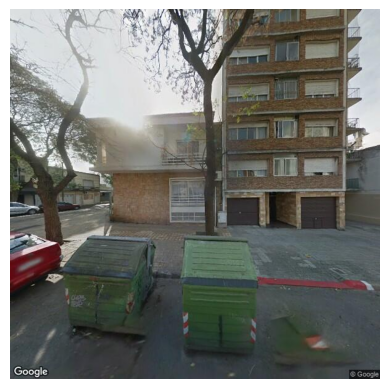

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(img_path)  # Replace with your image path

# Display the image
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()

In [ ]:
predicted_class

'clean'

In [39]:
!pip show keras

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow
